# Import libraries

In [2]:
from kafka import KafkaConsumer
import pandas as pd
from json import dumps
import numpy as np
from sklearn.metrics import classification_report,accuracy_score, recall_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
import joblib

In [2]:
consumer = KafkaConsumer(
    'ml-raw-dns',
    bootstrap_servers="localhost:9092",
    auto_offset_reset='earliest',
    enable_auto_commit=False
)


In [3]:
for m in consumer:
        x=m.value
        break

In [4]:
def data_cleaning(data):
   # remove timestamp column
    data = data.iloc[:,1:].copy()
    data['longest_word'] = data['longest_word'].astype('str')
    data['longest_word'] = data['longest_word'].apply(lambda x: x if any(c.isnumeric() for c in x) else len(x))
    modeSld = data['sld'].mode()[0]
    data['sld'] = data['sld'].replace(r'(([a-z]+)|([A-Z]+|(0-1)))',int(modeSld), regex=True).astype('int')
    data['FQDN_count'] = data['FQDN_count'].astype('int')
    return data.astype('float')
    


In [5]:
datasetStatic= pd.read_csv("Static_dataset.csv")
datasetStaticWithoutTime = data_cleaning(datasetStatic)

In [6]:
def getrecord_1000(itr):
    list_with_1000_record=[]
    i=0
    for m in consumer:
        
        if i <1000:
            list_with_1000_record.append(m.value)
            i=i+1
        else:
            
            break
    print(f"Window {itr}")
    return list_with_1000_record

In [7]:
column_names =["timestamp","FQDN_count","subdomain_length","upper","lower","numeric","entropy","special","labels","labels_max","labels_average","longest_word","sld","len","subdomain","Target Attack"]
def prepare_data(data):
    df=pd.DataFrame()
    list_of_row=[]
    for item in data:
        row_string=eval(item.decode("UTF-8"))
        row_string = row_string.strip()
        row= row_string.split(",")
        list_of_row.append(row)
    df=pd.DataFrame(list_of_row)
    df.columns=column_names
    return df
    
        

In [8]:
def retrain_model(data):
    
    pipe = joblib.load('piplineModelLGBM_final.pkl')
    X =data.drop(labels = ["Target Attack"], axis=1) 
    y=data["Target Attack"] 
    pipe.fit(X,y)
    return pipe

In [3]:
static_model = Dynamic_model= joblib.load('piplineModelLGBM_final.pkl')
Dynamic_model

Pipeline(steps=[('robustscaler', RobustScaler()),
                ('selectkbest', SelectKBest(k=9)),
                ('lgbmclassifier',
                 LGBMClassifier(min_child_samples=100, num_leaves=100,
                                random_state=42, reg_alpha=0.1))])

In [17]:
list_of_recall_Dynmaic_model=[]
list_of_recall_static_model=[]
for itr in range(267):
    r_dataset = getrecord_1000(itr+1)
    p_dataset =  prepare_data(r_dataset)
    new_dataset =  data_cleaning(p_dataset)
    X =new_dataset.drop(labels = ["Target Attack"], axis=1) 
    y=new_dataset["Target Attack"]
    #-ew_dataset = pd.concat([datasetStaticWithoutTime, new_dataset])
    print(new_dataset.shape)
    Dy_pred=Dynamic_model.predict(X)
    D_recall= recall_score(y, Dy_pred)
    D_acc= accuracy_score(y, Dy_pred)
    print(f"the Recall score (Class 1)  of Dynamic Model without retrain = {D_recall*100}%")
    print(f"the accuracy_score of Dynamic Model without retrain = {D_acc*100}%")
    new_dataset = pd.concat([datasetStaticWithoutTime, new_dataset])
    if D_recall < 0.999615 :
        print(" The model will be trained on the new data")
        Dynamic_model=retrain_model(new_dataset)
        Dy_pred=Dynamic_model.predict(X)
        D_recall=recall_score(y, Dy_pred)
        D_acc= accuracy_score(y, Dy_pred)
        print(f"the Recall score (Class 1)  of Dynamic Model after retrain = {D_recall*100}%")
        print(f"the accuracy_score of Dynamic Model after retrain = {D_acc*100}%")
    Sy_pred=static_model.predict(X)
    S_recall=recall_score(y, Sy_pred)
    S_acc= accuracy_score(y, Sy_pred)
    print(f"the Recall score (Class 1)  of Static Model = {S_recall*100}%")
    print(f"the accuracy_score of Static Model = {S_acc*100}%")
    list_of_recall_Dynmaic_model.append(D_recall)
    list_of_recall_static_model.append(S_recall)
    print(f"{'*'*20}")
   

Window 1
(1000, 15)
the Recall score (Class 1)  of Dynamic Model without retrain = 99.8062015503876%
the accuracy_score of Dynamic Model without retrain = 79.7%
 The model will be trained on the new data
the Recall score (Class 1)  of Dynamic Model after retrain = 99.8062015503876%
the accuracy_score of Dynamic Model after retrain = 79.7%
the Recall score (Class 1)  of Static Model = 99.8062015503876%
the accuracy_score of Static Model = 79.7%
********************
Window 2
(1000, 15)
the Recall score (Class 1)  of Dynamic Model without retrain = 100.0%
the accuracy_score of Dynamic Model without retrain = 79.4%
the Recall score (Class 1)  of Static Model = 100.0%
the accuracy_score of Static Model = 79.4%
********************
Window 3
(1000, 15)
the Recall score (Class 1)  of Dynamic Model without retrain = 99.822695035461%
the accuracy_score of Dynamic Model without retrain = 82.3%
 The model will be trained on the new data
the Recall score (Class 1)  of Dynamic Model after retrain = 

Window 23
(1000, 15)
the Recall score (Class 1)  of Dynamic Model without retrain = 99.63099630996311%
the accuracy_score of Dynamic Model without retrain = 81.2%
 The model will be trained on the new data
the Recall score (Class 1)  of Dynamic Model after retrain = 99.63099630996311%
the accuracy_score of Dynamic Model after retrain = 81.2%
the Recall score (Class 1)  of Static Model = 99.63099630996311%
the accuracy_score of Static Model = 81.2%
********************
Window 24
(1000, 15)
the Recall score (Class 1)  of Dynamic Model without retrain = 100.0%
the accuracy_score of Dynamic Model without retrain = 81.6%
the Recall score (Class 1)  of Static Model = 100.0%
the accuracy_score of Static Model = 81.6%
********************
Window 25
(1000, 15)
the Recall score (Class 1)  of Dynamic Model without retrain = 100.0%
the accuracy_score of Dynamic Model without retrain = 82.8%
the Recall score (Class 1)  of Static Model = 100.0%
the accuracy_score of Static Model = 82.8%
************

the Recall score (Class 1)  of Dynamic Model without retrain = 100.0%
the accuracy_score of Dynamic Model without retrain = 81.39999999999999%
the Recall score (Class 1)  of Static Model = 100.0%
the accuracy_score of Static Model = 81.5%
********************
Window 48
(1000, 15)
the Recall score (Class 1)  of Dynamic Model without retrain = 99.81308411214953%
the accuracy_score of Dynamic Model without retrain = 82.69999999999999%
 The model will be trained on the new data
the Recall score (Class 1)  of Dynamic Model after retrain = 99.81308411214953%
the accuracy_score of Dynamic Model after retrain = 82.69999999999999%
the Recall score (Class 1)  of Static Model = 99.81308411214953%
the accuracy_score of Static Model = 82.69999999999999%
********************
Window 49
(1000, 15)
the Recall score (Class 1)  of Dynamic Model without retrain = 100.0%
the accuracy_score of Dynamic Model without retrain = 81.6%
the Recall score (Class 1)  of Static Model = 100.0%
the accuracy_score of St

Window 72
(1000, 15)
the Recall score (Class 1)  of Dynamic Model without retrain = 100.0%
the accuracy_score of Dynamic Model without retrain = 80.30000000000001%
the Recall score (Class 1)  of Static Model = 100.0%
the accuracy_score of Static Model = 80.30000000000001%
********************
Window 73
(1000, 15)
the Recall score (Class 1)  of Dynamic Model without retrain = 100.0%
the accuracy_score of Dynamic Model without retrain = 82.0%
the Recall score (Class 1)  of Static Model = 100.0%
the accuracy_score of Static Model = 82.0%
********************
Window 74
(1000, 15)
the Recall score (Class 1)  of Dynamic Model without retrain = 100.0%
the accuracy_score of Dynamic Model without retrain = 79.10000000000001%
the Recall score (Class 1)  of Static Model = 100.0%
the accuracy_score of Static Model = 79.10000000000001%
********************
Window 75
(1000, 15)
the Recall score (Class 1)  of Dynamic Model without retrain = 99.81481481481481%
the accuracy_score of Dynamic Model witho

Window 95
(1000, 15)
the Recall score (Class 1)  of Dynamic Model without retrain = 100.0%
the accuracy_score of Dynamic Model without retrain = 82.19999999999999%
the Recall score (Class 1)  of Static Model = 100.0%
the accuracy_score of Static Model = 82.19999999999999%
********************
Window 96
(1000, 15)
the Recall score (Class 1)  of Dynamic Model without retrain = 100.0%
the accuracy_score of Dynamic Model without retrain = 80.30000000000001%
the Recall score (Class 1)  of Static Model = 100.0%
the accuracy_score of Static Model = 80.30000000000001%
********************
Window 97
(1000, 15)
the Recall score (Class 1)  of Dynamic Model without retrain = 100.0%
the accuracy_score of Dynamic Model without retrain = 81.10000000000001%
the Recall score (Class 1)  of Static Model = 100.0%
the accuracy_score of Static Model = 81.10000000000001%
********************
Window 98
(1000, 15)
the Recall score (Class 1)  of Dynamic Model without retrain = 100.0%
the accuracy_score of Dynam

the Recall score (Class 1)  of Static Model = 100.0%
the accuracy_score of Static Model = 81.8%
********************
Window 120
(1000, 15)
the Recall score (Class 1)  of Dynamic Model without retrain = 100.0%
the accuracy_score of Dynamic Model without retrain = 81.0%
the Recall score (Class 1)  of Static Model = 100.0%
the accuracy_score of Static Model = 81.0%
********************
Window 121
(1000, 15)
the Recall score (Class 1)  of Dynamic Model without retrain = 100.0%
the accuracy_score of Dynamic Model without retrain = 80.9%
the Recall score (Class 1)  of Static Model = 100.0%
the accuracy_score of Static Model = 80.9%
********************
Window 122
(1000, 15)
the Recall score (Class 1)  of Dynamic Model without retrain = 100.0%
the accuracy_score of Dynamic Model without retrain = 81.89999999999999%
the Recall score (Class 1)  of Static Model = 100.0%
the accuracy_score of Static Model = 81.89999999999999%
********************
Window 123
(1000, 15)
the Recall score (Class 1)  

the Recall score (Class 1)  of Dynamic Model after retrain = 99.822695035461%
the accuracy_score of Dynamic Model after retrain = 81.5%
the Recall score (Class 1)  of Static Model = 99.822695035461%
the accuracy_score of Static Model = 81.5%
********************
Window 146
(1000, 15)
the Recall score (Class 1)  of Dynamic Model without retrain = 100.0%
the accuracy_score of Dynamic Model without retrain = 79.5%
the Recall score (Class 1)  of Static Model = 100.0%
the accuracy_score of Static Model = 79.5%
********************
Window 147
(1000, 15)
the Recall score (Class 1)  of Dynamic Model without retrain = 100.0%
the accuracy_score of Dynamic Model without retrain = 81.39999999999999%
the Recall score (Class 1)  of Static Model = 100.0%
the accuracy_score of Static Model = 81.39999999999999%
********************
Window 148
(1000, 15)
the Recall score (Class 1)  of Dynamic Model without retrain = 100.0%
the accuracy_score of Dynamic Model without retrain = 78.8%
the Recall score (Cla

Window 174
(1000, 15)
the Recall score (Class 1)  of Dynamic Model without retrain = 100.0%
the accuracy_score of Dynamic Model without retrain = 83.3%
the Recall score (Class 1)  of Static Model = 100.0%
the accuracy_score of Static Model = 83.3%
********************
Window 175
(1000, 15)
the Recall score (Class 1)  of Dynamic Model without retrain = 100.0%
the accuracy_score of Dynamic Model without retrain = 81.10000000000001%
the Recall score (Class 1)  of Static Model = 100.0%
the accuracy_score of Static Model = 81.10000000000001%
********************
Window 176
(1000, 15)
the Recall score (Class 1)  of Dynamic Model without retrain = 100.0%
the accuracy_score of Dynamic Model without retrain = 80.9%
the Recall score (Class 1)  of Static Model = 100.0%
the accuracy_score of Static Model = 80.9%
********************
Window 177
(1000, 15)
the Recall score (Class 1)  of Dynamic Model without retrain = 100.0%
the accuracy_score of Dynamic Model without retrain = 81.89999999999999%
th

Window 202
(1000, 15)
the Recall score (Class 1)  of Dynamic Model without retrain = 100.0%
the accuracy_score of Dynamic Model without retrain = 81.39999999999999%
the Recall score (Class 1)  of Static Model = 100.0%
the accuracy_score of Static Model = 81.39999999999999%
********************
Window 203
(1000, 15)
the Recall score (Class 1)  of Dynamic Model without retrain = 100.0%
the accuracy_score of Dynamic Model without retrain = 83.1%
the Recall score (Class 1)  of Static Model = 100.0%
the accuracy_score of Static Model = 83.1%
********************
Window 204
(1000, 15)
the Recall score (Class 1)  of Dynamic Model without retrain = 99.82578397212544%
the accuracy_score of Dynamic Model without retrain = 81.3%
 The model will be trained on the new data
the Recall score (Class 1)  of Dynamic Model after retrain = 99.82578397212544%
the accuracy_score of Dynamic Model after retrain = 81.3%
the Recall score (Class 1)  of Static Model = 99.82578397212544%
the accuracy_score of Stat

Window 225
(1000, 15)
the Recall score (Class 1)  of Dynamic Model without retrain = 100.0%
the accuracy_score of Dynamic Model without retrain = 80.9%
the Recall score (Class 1)  of Static Model = 100.0%
the accuracy_score of Static Model = 80.9%
********************
Window 226
(1000, 15)
the Recall score (Class 1)  of Dynamic Model without retrain = 100.0%
the accuracy_score of Dynamic Model without retrain = 83.39999999999999%
the Recall score (Class 1)  of Static Model = 100.0%
the accuracy_score of Static Model = 83.39999999999999%
********************
Window 227
(1000, 15)
the Recall score (Class 1)  of Dynamic Model without retrain = 99.82046678635548%
the accuracy_score of Dynamic Model without retrain = 82.6%
 The model will be trained on the new data
the Recall score (Class 1)  of Dynamic Model after retrain = 99.82046678635548%
the accuracy_score of Dynamic Model after retrain = 82.6%
the Recall score (Class 1)  of Static Model = 99.82046678635548%
the accuracy_score of Stat

the Recall score (Class 1)  of Dynamic Model after retrain = 99.8109640831758%
the accuracy_score of Dynamic Model after retrain = 80.10000000000001%
the Recall score (Class 1)  of Static Model = 99.8109640831758%
the accuracy_score of Static Model = 80.10000000000001%
********************
Window 250
(1000, 15)
the Recall score (Class 1)  of Dynamic Model without retrain = 99.63833634719711%
the accuracy_score of Dynamic Model without retrain = 81.39999999999999%
 The model will be trained on the new data
the Recall score (Class 1)  of Dynamic Model after retrain = 99.63833634719711%
the accuracy_score of Dynamic Model after retrain = 81.39999999999999%
the Recall score (Class 1)  of Static Model = 99.63833634719711%
the accuracy_score of Static Model = 81.39999999999999%
********************
Window 251
(1000, 15)
the Recall score (Class 1)  of Dynamic Model without retrain = 99.81785063752277%
the accuracy_score of Dynamic Model without retrain = 82.19999999999999%
 The model will be 

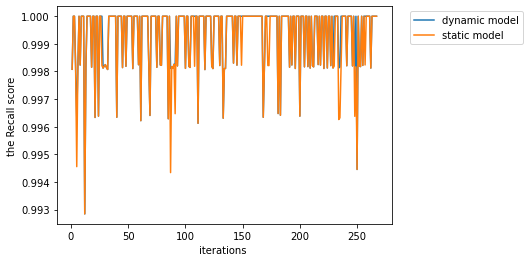

In [13]:
import matplotlib.pyplot as plt
plt.plot(range(1, 268), list_of_recall_Dynmaic_model, label=f'dynamic model')
plt.plot(range(1, 268),list_of_recall_static_model, label=f'static model')
plt.xlabel('iterations ')
#plt.xticks(range(1, 251))
plt.ylabel("the Recall score")
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")